<a href="https://colab.research.google.com/github/areias/viral-escape/blob/main/FluBERTa_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Check GPU and RAM specifications

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb  6 20:39:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 2.  Load Flu dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# install dependencies
! pip install anndata 

     |████████████████████████████████| 91 kB 4.0 MB/s 


In [5]:
! pip install scanpy

     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 70.5 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=95693c0f4b028df0c84a809a3a7b9c9562426092a3bbb01a0592ade1e7c863e0
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=1a0820bfa755e9b93aed6107d68ea5cb13cab16abde21aa83232333153a896e4
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=bcbd8bfa5394bc5a93b3e356c2fc20d40ef685bb5677f18d32b29e4d5bd9d819
  Stored in directory: /root/.cache/pip/wheels/68/ca/56/344d532fe53e855ccd6549795d370588ab8123

In [6]:
! pip install bio


     |████████████████████████████████| 271 kB 4.0 MB/s 
     |████████████████████████████████| 2.3 MB 75.5 MB/s 


In [3]:
AAs = [
        'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z'
    ]
    
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }



In [4]:
import pickle 

In [5]:
with open('drive/MyDrive/FluBERTa/train_seqs.pkl', 'rb') as handle:
   train_seqs = pickle.load(handle)

In [ ]:
with open('drive/MyDrive/FluBERTa/test_seqs.pkl', 'rb') as handle:
    test_seqs = pickle.load(handle)

In [6]:
# Seals get the flu too!
train_seqs[list(train_seqs.keys())[0]]

[{'Collection Date': 2009,
  'Complete Genome': 'Yes',
  'Country': 'Denmark',
  'Flu Season': '09-10',
  'Host Species': 'human',
  'Name': 'HA',
  'Segment': '4',
  'Segment Length': '1752',
  'Sequence Accession': 'CY083910',
  'State/Province': '-N/A-',
  'Strain Name': 'A/Aalborg/INS132/2009(H1N1)',
  'Subtype': 'H1'},
 {'Collection Date': 2009,
  'Complete Genome': 'Yes',
  'Country': 'Denmark',
  'Flu Season': '09-10',
  'Host Species': 'human',
  'Name': 'HA',
  'Segment': '4',
  'Segment Length': '1734',
  'Sequence Accession': 'CY066975',
  'State/Province': '-N/A-',
  'Strain Name': 'A/Aarhus/INS242/2009(H1N1)',
  'Subtype': 'H1'},
 {'Collection Date': 2009,
  'Complete Genome': 'Yes',
  'Country': 'Germany',
  'Flu Season': '09-10',
  'Host Species': 'human',
  'Name': 'HA',
  'Segment': '4',
  'Segment Length': '1734',
  'Sequence Accession': 'CY072222',
  'State/Province': '-N/A-',
  'Strain Name': 'A/Frankfurt/INS302/2009(H1N1)',
  'Subtype': 'H1'},
 {'Collection Date': 

In [12]:
len(train_seqs)

37368

## 3. Load RoBERTa model

In [13]:
! pip install transformers

     |████████████████████████████████| 3.5 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 6.8 MB 83.6 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [14]:
! pip install tokenizers

In [15]:
# Check that PyTorch sees it
import torch
torch.cuda.is_available()

True

In [7]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="drive/MyDrive/FluBERTa/tokenizer/tokenizer-flu.json",
                                         pad_token='<pad>',
                                         bos_token='<s>',
                                         eos_token='</s>',
                                         mask_token='<mask>',
                                         unk_token='<unk>',
                                         max_len=512,
                                         padding='max_length')


### Embeddings

>Model Output.Without adding any task-specific heads to thearchitecture, the model output is a list of𝑙=512vectors, each withlength𝑑=768. The first vector, which corresponds to the special[CLS]token, acts as an aggregate sequence representation whichwe use for sequence classification tasks. We refer to the entireoutput as the deep representation of the amino acid sequence.(https://dl.acm.org/doi/pdf/10.1145/3388440.3412467)

>We created protein embeddings by concatenatingthe vectors of each protein’s first 128 tokens and plotted the firsttwo principal components of thirty proteins from seven relatedprotein families (Figure 2). We concatenated the vectors becausethe concatenated vectors appeared to provide better visualizationresults than the [CLS] token

In [8]:
# load model
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM.from_pretrained("drive/MyDrive/FluBERTa/checkpoint-11940")
model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(10000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [9]:
import pandas as pd 
import numpy as np

In [10]:
#logits (torch.FloatTensor of shape (batch_size, sequence_length, config.vocab_size)) — 
#Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).


# Hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True 
# is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the
# output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
# Hidden-states of the model at the output of each layer plus the initial embedding outputs.


# so output[0] is the logits, output[1] are the hidden states of which the first one is the embeddings output output[1][0]



In [11]:
# https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#3-extracting-embeddings
# Calculate the average of all token vectors 


In [12]:
#logits (torch.FloatTensor of shape (batch_size, sequence_length, config.vocab_size)) — 
#Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).



In [29]:
# from collections import defaultdict 

# seqs= defaultdict(dict)

# for x in list(train_seqs)[0:400]:
#     seqs[x] = train_seqs[x]

In [57]:
seqs=train_seqs

In [58]:
len(seqs)

37368

In [35]:
import tensorflow as tf

In [59]:
sorted_seqs = sorted(seqs.keys())
sorted_seqs=list(map(str,sorted_seqs))

In [60]:
sorted_seqs[:3]

['GYKMNTQILVFALVAIIPTTADKICLGHHAVTNGTKVNTLTERGVEVVNATDTVERTNVPRICSKGKRTVDLGQCGLLGTITGPPQCDQFLEFSADLIIERREGSDVCYPGKFVNEEALRQILRESGGINKETMGFTYSGIRTNGATSTCRRSGSSFYAEMKWLLSNTDNAAFPQMTKSYKNTRKDPALIIWGIHHSGSTTEQTKLYGSGNKLITVESSNYQQSFVPSPGARPKVDGQSGRIDFHWLMLNPNDTITFSFNGAFIAPDRASFLRGKSMGIQSGVQVDDNCEGDCYHSGGTIISNLPFQNINSRAVGKCPRYVKQESLMLATGMKNVPEIPKGRGLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAIDQITGKLNRLIEKTNQQFELIDNEFTEVEKQIGNVINWTRDSMTEVWSYNAELLVAMENQHTIDLADSEMNKLYERVRRQLRENAEEDGTGCFEIFHKCDDDCMASIRNNTYDHSKYREEAMQNRIQIDPVKLSSGYKDVILWFSFGASCFILLAIAMGLVFICVKNGNMRCTICI',
 'ICQMEKIVLLFAIVSLVKSDQICIGYHANNSTEQVDTIMEKNVTVTHAQDILEKTHNGKLCDLDGVKPLILRDCSVAGWLLGNPMCDEFINVPEWSYIVEKANPVNDLCYPGDFNDYEELKHLLSRINHFEKIQIIPKSSWSSHEASLGVSSACPYQRKSSFFRNVVWLIKKNSTYPTIKRSYNNTNQEDLLVLWGIHHPNDAAEQTKLYQNPTTYISVGTSTLNQRLVPRIATRSKVNGQSGRMEFFWTILKPNDAINFESNGNFIAPEYAYKIVKKGDSTIMKSELEYGNCNTKCQTPMGAINSSMPFHNIHPLTIGECPKYVKSNRLVLATGLRNSPQRERRRKKRGLFGAIAGFIEGGWQGMVDGWYGYHHSNEQGSGYAADKESTQKAIDGVTNKVNSIIDKMNTQFEAVGREFNNLERRIENLN

In [33]:
import math


In [61]:
X_embed_cat = []
inference_batch_size = 100
n_samples = len(sorted_seqs)
n_batches = math.ceil(n_samples / inference_batch_size)
n_batches

374

In [62]:
%%time
print('Embedding...')
prog_bar = tf.keras.utils.Progbar(n_batches)
for batchi in range(n_batches):
    start = batchi * inference_batch_size
    end = min((batchi + 1) * inference_batch_size, n_samples)
    X_batch = sorted_seqs[start:end]
    inputs = fast_tokenizer(X_batch, return_tensors='pt',truncation=True, max_length=128, pad_to_max_length=True)
    outputs=model(inputs.input_ids, output_hidden_states=True)
    sentence_embeddings=[x.detach().numpy().mean(axis=0)  for x in outputs[1][0]]
    X_embed_cat.append(sentence_embeddings)
    prog_bar.add(1)
print('Done embedding.')


Embedding...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


374/374 [==============================] - 6584s 18s/step
Done embedding.
CPU times: user 3h 58min 57s, sys: 1min 47s, total: 4h 44s
Wall time: 1h 49min 44s


In [63]:
len(X_batch)

68

In [64]:
len(X_embed_cat)

374

In [65]:
X_embed_cat = np.concatenate(X_embed_cat)


In [66]:
X_embed_cat.shape

(37368, 768)

In [1]:
embed_fname = 'drive/MyDrive/FluBERTa/embeddings'
np.save(embed_fname, X_embed_cat)

NameError: ignored

In [44]:
# add embedding to sequence dictionary
for seq_idx, seq in enumerate(sorted_seqs):
    for meta in seqs[seq]:
        meta['embedding'] = X_embed_cat[seq_idx]

In [45]:
seqs[list(seqs.keys())[0]]

[{'Collection Date': 2009,
  'Complete Genome': 'Yes',
  'Country': 'Denmark',
  'Flu Season': '09-10',
  'Host Species': 'human',
  'Name': 'HA',
  'Segment': '4',
  'Segment Length': '1752',
  'Sequence Accession': 'CY083910',
  'State/Province': '-N/A-',
  'Strain Name': 'A/Aalborg/INS132/2009(H1N1)',
  'Subtype': 'H1',
  'embedding': array([ 1.30487561e+00,  1.33058369e-01, -6.88494802e-01,  1.17142558e+00,
          2.60746002e-01, -4.26065177e-01,  7.93154716e-01,  3.46164823e-01,
          1.05094902e-01,  1.19480729e-01, -2.01651275e-01,  5.09693384e-01,
          2.66118050e-01, -2.10989758e-01,  9.97354165e-02,  2.77676404e-01,
         -6.62338912e-01, -5.05738378e-01, -1.82475910e-01,  4.87310886e-01,
         -7.56344795e-01,  5.04033267e-01, -9.68960524e-01,  9.36533436e-02,
          1.00785762e-01,  5.13234317e-01, -1.16982806e+00,  1.55662382e+00,
         -4.78555471e-01, -4.73722309e-01, -6.78467035e-01, -6.52724922e-01,
          3.37733120e-01,  2.19928011e-01, -1.

In [108]:

for meta in seqs[list(seqs.keys())[0]]:
    print(meta)

{'Name': 'HA', 'Sequence Accession': 'CY083910', 'Complete Genome': 'Yes', 'Segment': '4', 'Segment Length': '1752', 'Subtype': 'H1', 'Collection Date': 2009, 'Host Species': 'human', 'Country': 'Denmark', 'State/Province': '-N/A-', 'Flu Season': '09-10', 'Strain Name': 'A/Aalborg/INS132/2009(H1N1)', 'embedding': array([ 1.30487549e+00,  1.33058399e-01, -6.88494742e-01,  1.17142582e+00,
        2.60746062e-01, -4.26065207e-01,  7.93154478e-01,  3.46164882e-01,
        1.05094925e-01,  1.19480737e-01, -2.01651335e-01,  5.09693325e-01,
        2.66118079e-01, -2.10989743e-01,  9.97354090e-02,  2.77676433e-01,
       -6.62338912e-01, -5.05738378e-01, -1.82475850e-01,  4.87310916e-01,
       -7.56344795e-01,  5.04033327e-01, -9.68960524e-01,  9.36533660e-02,
        1.00785747e-01,  5.13234258e-01, -1.16982794e+00,  1.55662394e+00,
       -4.78555441e-01, -4.73722398e-01, -6.78467155e-01, -6.52724922e-01,
        3.37733090e-01,  2.19927981e-01, -1.39162660e+00,  7.63441086e-01,
        9.

In [46]:
from collections import Counter 
X, obs = [], {}
obs['n_seq'] = []
obs['seq'] = []
for seq in seqs:
    meta = seqs[seq][0]
    X.append(meta['embedding'])
    for key in meta:
        if key == 'embedding':
            continue
        if key not in obs:
            obs[key] = []
        obs[key].append(Counter([
            meta[key] for meta in seqs[seq]
        ]).most_common(1)[0][0])
    obs['n_seq'].append(len(seqs[seq]))
    obs['seq'].append(str(seq))
X = np.array(X)
    

In [47]:
X.shape

(400, 768)

In [48]:
len(obs)

14

In [49]:
obs.keys()

dict_keys(['n_seq', 'seq', 'Name', 'Sequence Accession', 'Complete Genome', 'Segment', 'Segment Length', 'Subtype', 'Collection Date', 'Host Species', 'Country', 'State/Province', 'Flu Season', 'Strain Name'])

In [50]:
from anndata import AnnData

In [51]:
adata = AnnData(X)
for key in obs:
    adata.obs[key] = obs[key]
adata = adata[
    np.logical_or.reduce((
        adata.obs['Host Species'] == 'human',
        adata.obs['Host Species'] == 'avian',
        adata.obs['Host Species'] == 'swine',
    ))
    ]

In [52]:
import scanpy as sc

In [53]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [121]:
! pip install igraph
! pip install louvain

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [54]:
sc.tl.louvain(adata, resolution=1.)

In [123]:
! pip install umap-learn[plot]

     |████████████████████████████████| 15.8 MB 4.3 MB/s 
     |████████████████████████████████| 76 kB 6.9 MB/s 
     |████████████████████████████████| 133 kB 64.3 MB/s 
     |████████████████████████████████| 830 kB 56.9 MB/s 
     |████████████████████████████████| 822 kB 77.4 MB/s 
     |████████████████████████████████| 802 kB 65.0 MB/s 
     |████████████████████████████████| 802 kB 76.1 MB/s 
     |████████████████████████████████| 793 kB 59.0 MB/s 
     |████████████████████████████████| 793 kB 25.0 MB/s 
     |████████████████████████████████| 791 kB 62.1 MB/s 
     |████████████████████████████████| 786 kB 58.7 MB/s 
     |████████████████████████████████| 779 kB 25.5 MB/s 
     |████████████████████████████████| 778 kB 48.5 MB/s 
     |████████████████████████████████| 776 kB 63.7 MB/s 
     |████████████████████████████████| 769 kB 55.1 MB/s 
     |████████████████████████████████| 766 kB 56.4 MB/s 
     |████████████████████████████████| 1.0 MB 89.7 MB/s 
     |██████████

In [55]:
def plot_umap(adata, namespace='flu'):
    if namespace == 'flu1918':
        plt.figure()
        ax = plt.gca()
        sc.pl.umap(adata, color='Host Species', ax=ax, size=20)
        ratio = 0.3
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        plt.savefig('figures/umap_{}_species.png'.format(namespace))
        plt.close()
    else:
        sc.pl.umap(adata, color='Host Species',
                   save='_{}_species.png'.format(namespace))

    sc.pl.umap(adata, color='Subtype',
               save='_{}_subtype.png'.format(namespace))
    sc.pl.umap(adata, color='Collection Date',
               save='_{}_date.png'.format(namespace))
    sc.pl.umap(adata, color='louvain',
               save='_{}_louvain.png'.format(namespace))

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Name' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Complete Genome' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new C

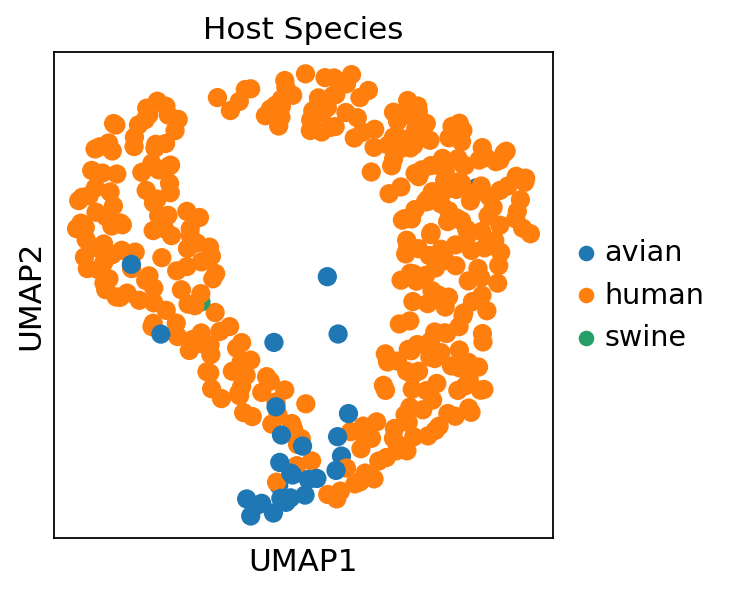

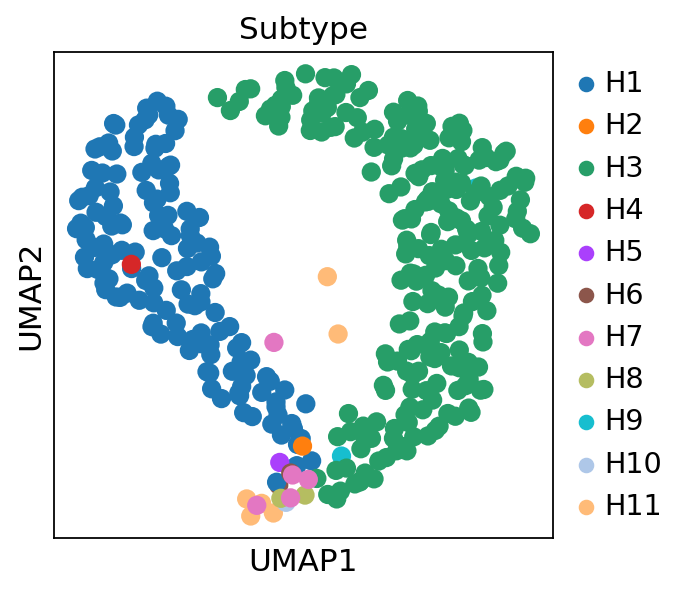

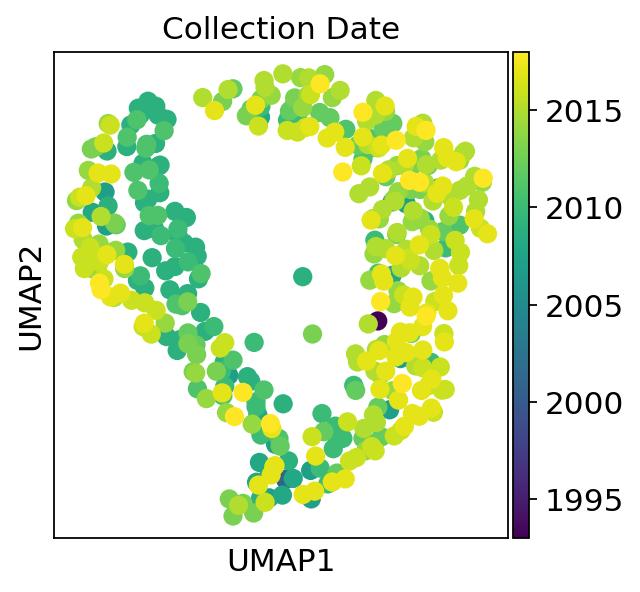

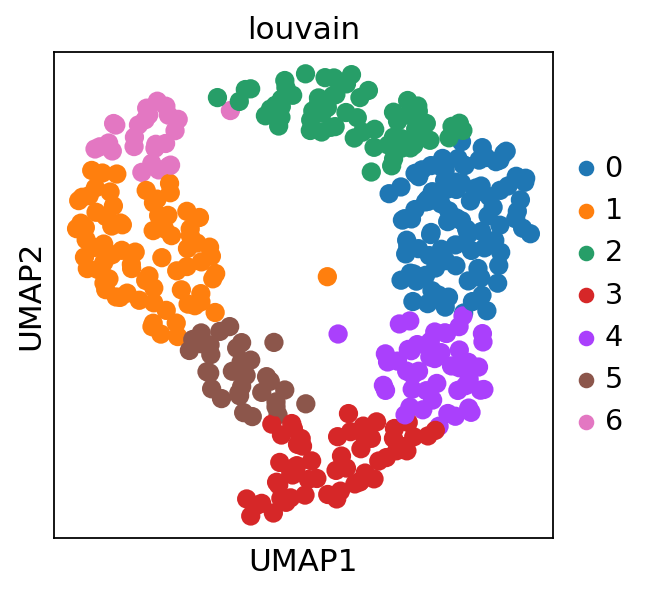

In [56]:
import umap
import umap.plot
sc.set_figure_params(dpi_save=500)

sc.tl.umap(adata, min_dist=1.)
plot_umap(adata)

## 4. Results

### 4.1. Influenza HA semantic embedding UMAPs and statistics 


> ... to understand the semantic patterns learned by our viral language models ... We therefore visualized the semantic
embeddings of each sequence in the influenza, HIV, and coronavirus corpuses using Uniform Manifold Approximation and Projection (UMAP) (13). The resulting two-dimensional semantic landscapes show clustering patterns that correspond to subtype, host species, or both (Fig. 2), suggesting that the model was able to learn functionally meaningful patterns from raw sequence.


Our model trained on only 1,000 sequences for 3 epochs achieves relatively good clustering results as can be visualized by the [graphs](#cell-id) and the following cluster purity statistics:

* Purity, Louvain and subtype: 0.699
* Purity, Louvain and host species: 0.896

For comparison, the full model achieves average cluster purities for HA subtype and HA host species of 99, 96%, respectively.


Of course the embeddings obtained from the full model encode a lot more information when you compare our UMAP graphs with the full model graphs that show a much more disperse landscape.

<insert original graph here>




In [ ]:
! python viral-mutation/bin/flu.py bilstm --checkpoint drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5 --embed > flu_embed.log 2>&1

/bin/bash: line 1:   753 Killed                  python viral-mutation/bin/flu.py bilstm --checkpoint drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5 --embed > flu_embed.log 2>&1


In [ ]:
# from bin/flu.py
analyze_embedding(args, model, seqs, vocabulary)


In [ ]:
from collections import namedtuple
arguments = namedtuple('arguments', ['model_name',
                                     'dim','n_epochs','batch_size',
                                     'namespace','seed','checkpoint'])

args = arguments('bilstm',512,3,350, # defaults were batch-size 1000, 14 epochs
                 'flu',1, "drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5")
args

arguments(model_name='bilstm', dim=512, n_epochs=3, batch_size=350, namespace='flu', seed=1, checkpoint='drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5')

In [ ]:
# from bin/flu.py
from flu import *


In [ ]:
fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies.fa' ]
meta_fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies_meta.tsv' ]

seqs = process(fnames, meta_fnames)


In [ ]:
from collections import defaultdict 

seqs_subset= defaultdict(dict)

for x in list(seqs)[0:1000]:
    seqs_subset[x] = seqs[x]


In [ ]:
seq_len = max([ len(seq) for seq in seqs_subset ]) + 2
vocab_size = len(AAs) + 2


In [ ]:
#from keras.models import load_model
#model = load_model('drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5')


from language_model import BiLSTMLanguageModel
model = BiLSTMLanguageModel(
    seq_len,
    vocab_size,
    embedding_dim=20,
    hidden_dim=args.dim,
    n_hidden=2,
    n_epochs=args.n_epochs,
    batch_size=args.batch_size,
    inference_batch_size=350,
    seed=args.seed,
    verbose=True,
)



In [ ]:
model.model_.load_weights(args.checkpoint)
tprint('Model summary:')
tprint(model.model_.summary())


2022-01-04 16:34:45.462981 | Model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 569)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 569)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 569, 20)      580         ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 569, 512)  

In [ ]:
! pip install igraph

     |████████████████████████████████| 3.2 MB 8.1 MB/s 


In [ ]:
! pip install louvain

     |████████████████████████████████| 1.1 MB 7.3 MB/s 


In [ ]:
import importlib

In [ ]:

importlib.reload(sys.modules['flu'])
from flu import *

In [ ]:
!mkdir target/flu/clusters

<a name="cell-id"></a>
#### UMAP graphs 



... storing 'Name' as categorical
... storing 'Complete Genome' as categorical
... storing 'Segment' as categorical
... storing 'Segment Length' as categorical
... storing 'Subtype' as categorical
... storing 'Host Species' as categorical
... storing 'Country' as categorical
... storing 'State/Province' as categorical
... storing 'Flu Season' as categorical
... storing 'Strain Name' as categorical


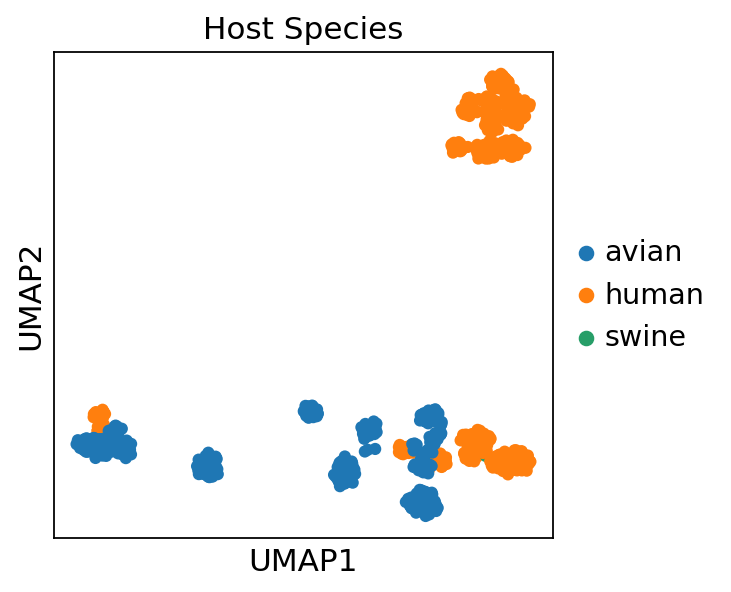

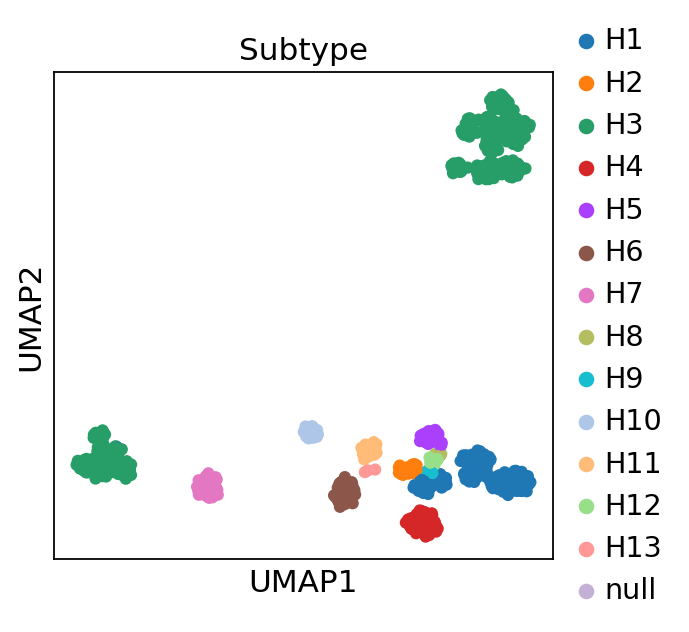

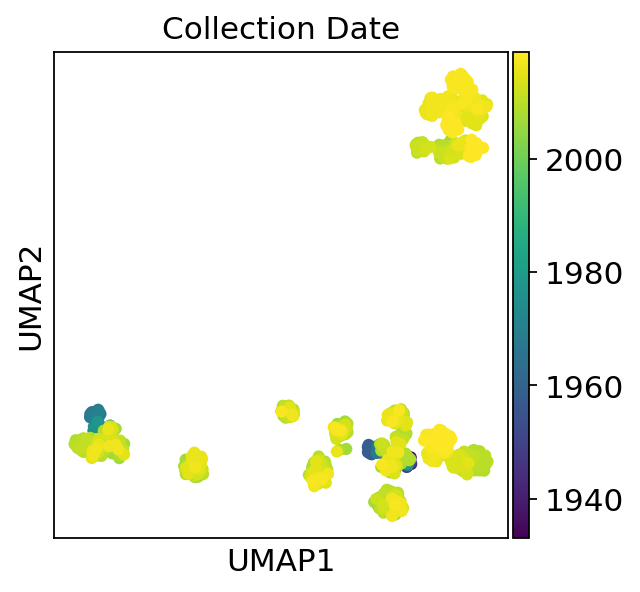

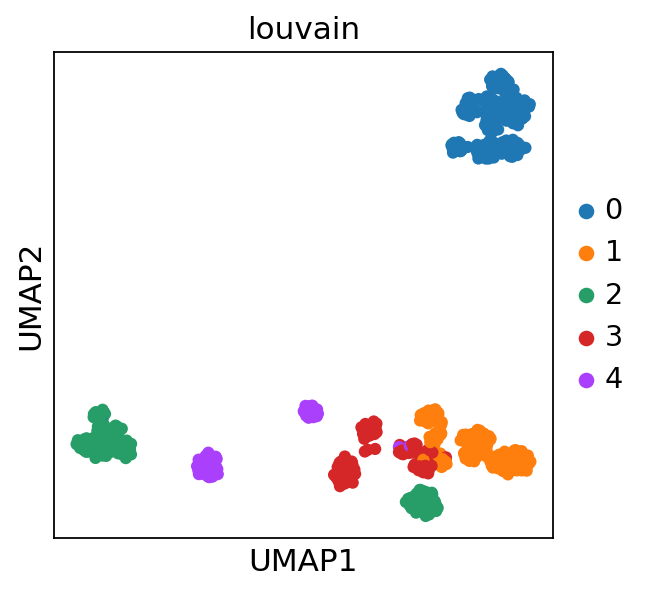

2022-01-04 15:47:55.696858 | Cluster 0
2022-01-04 15:47:55.714900 | 	Collection Date:
2022-01-04 15:47:55.715841 | 		2017: 55
2022-01-04 15:47:55.716675 | 		2015: 48
2022-01-04 15:47:55.717674 | 		2018: 42
2022-01-04 15:47:55.718793 | 		2019: 35
2022-01-04 15:47:55.719917 | 		2016: 31
2022-01-04 15:47:55.720817 | 		2014: 28
2022-01-04 15:47:55.721699 | 		2012: 20
2022-01-04 15:47:55.722947 | 		2010: 13
2022-01-04 15:47:55.724258 | 		2013: 9
2022-01-04 15:47:55.725249 | 		2011: 6
2022-01-04 15:47:55.726345 | 		2007: 4
2022-01-04 15:47:55.727531 | 		2008: 3
2022-01-04 15:47:55.728743 | 		2009: 1
2022-01-04 15:47:55.729832 | 		1978: 1
2022-01-04 15:47:55.731109 | 	Country:
2022-01-04 15:47:55.732583 | 		USA: 255
2022-01-04 15:47:55.733643 | 		Canada: 26
2022-01-04 15:47:55.734643 | 		Iran: 5
2022-01-04 15:47:55.736010 | 		Brazil: 3
2022-01-04 15:47:55.737117 | 		Peru: 2
2022-01-04 15:47:55.738167 | 		Australia: 2
2022-01-04 15:47:55.739555 | 		Switzerland: 2
2022-01-04 15:47:55.740593 | 	

In [ ]:
# commented out umap 1918 flu since I think there are no observation in my subset
analyze_embedding(args, model, seqs_subset, vocabulary)



###  4.2. Single-residue escape prediction using validation data from Doud et al. (2018) and Lee et al. (2019) 

> ... we then tested whether combining seman-
tic change and grammaticality enables us to
predict mutations that lead to viral escape.
Our experimental setup involved making, in
silico, all possible single-residue mutations
to a given viral protein sequence; next, each
mutant was ranked according to the CSCS
objective that combines semantic change and
grammaticality. We validated this ranking on
the basis of enrichment of experimentally verified mutants that causally induce escape from
neutralizing antibodies. 

> We computed the area under the curve
(AUC) of acquired escape mutations versus the
total acquired mutations (12). ... escape prediction with CSCS resulted in **both statistically significant and strong AUCs of
0.81, 0.73 for H1 WSN33 and H3 Perth09.**


In comparison, our 1,000 sequences model for H1 WSN33 results in AUC of 
* AUC (CSCS): 0.6943165566179895, P = 0.0
* AUC (semantic change only): 0.5365467547056084
* AUC (grammaticality only): 0.7185742075125345

I still have yet to run the code for H3 Perth09.




The validation data consists of:
* Escape single-residue DMS of HA H1 WSN33 from Doud et al.
(2018); 
* Escape single-residue DMS of HA H3 Perth09 from
Lee et al. (2019)


In [ ]:
# add to to path
import sys
sys.path.append('viral-mutation/bin')

In [ ]:
# load vocabulary
AAs = [
        'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z'
    ]
    
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }



In [ ]:
# load args
from collections import namedtuple
arguments = namedtuple('arguments', ['model_name','namespace','checkpoint',
                                      'dim','n_epochs','batch_size','seed'])

args = arguments('bilstm', 'flu', 'drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5',
                 512,3,350,1)
args

arguments(model_name='bilstm', namespace='flu', checkpoint='drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5', dim=512, n_epochs=3, batch_size=350, seed=1)

In [ ]:
# load model
from flu import * 

fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies.fa' ]
meta_fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies_meta.tsv' ]

seqs = process(fnames, meta_fnames)

from collections import defaultdict 

seqs_subset= defaultdict(dict)

for x in list(seqs)[0:1000]:
    seqs_subset[x] = seqs[x]

seq_len = max([ len(seq) for seq in seqs_subset ]) + 2
vocab_size = len(AAs) + 2

from language_model import BiLSTMLanguageModel
model = BiLSTMLanguageModel(
    seq_len,
    vocab_size,
    embedding_dim=20,
    hidden_dim=args.dim,
    n_hidden=2,
    n_epochs=args.n_epochs,
    batch_size=args.batch_size,
    inference_batch_size=350,
    seed=args.seed,
    verbose=True,
)
model.model_.load_weights(args.checkpoint)


In [ ]:
# from flu.py

from escape import load_doud2018, load_lee2019

tprint('Lee et al. 2018...')
seq_to_mutate, escape_seqs = load_doud2018()

"""
analyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,
                    prob_cutoff=0., beta=1., plot_acquisition=True,
                    plot_namespace='flu_h1')
tprint('')

tprint('Lee et al. 2019...')
seq_to_mutate, escape_seqs = load_lee2019()
analyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,
                    prob_cutoff=0., beta=1., plot_acquisition=True,
                    plot_namespace='flu_h3')
"""

2022-01-04 17:44:41.871110 | Lee et al. 2018...


"\nanalyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,\n                    prob_cutoff=0., beta=1., plot_acquisition=True,\n                    plot_namespace='flu_h1')\ntprint('')\n\ntprint('Lee et al. 2019...')\nseq_to_mutate, escape_seqs = load_lee2019()\nanalyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,\n                    prob_cutoff=0., beta=1., plot_acquisition=True,\n                    plot_namespace='flu_h3')\n"

In [ ]:
len(seq_to_mutate)

565

In [ ]:
len(escape_seqs)

10736

In [ ]:
y_pred = predict_sequence_prob(
    args, seq_to_mutate, vocabulary, model, verbose=True)

In [ ]:
y_pred

array([[1.07561533e-08, 1.31496345e-05, 1.57059489e-07, ...,
        9.99410868e-01, 2.38247725e-12, 8.42569392e-09],
       [3.64688990e-09, 3.87536420e-06, 1.95696600e-07, ...,
        3.02035223e-05, 8.40067078e-12, 4.15505630e-09],
       [6.08486152e-06, 9.61071532e-03, 1.47017636e-04, ...,
        1.86240271e-04, 3.31790403e-07, 1.16440306e-05],
       ...,
       [1.49749735e-09, 2.34280506e-09, 4.94858732e-09, ...,
        1.41904240e-11, 6.38366089e-07, 7.48250129e-10],
       [1.90206695e-08, 2.29081056e-08, 1.98895208e-07, ...,
        6.88880966e-11, 8.39728891e-05, 1.31131577e-08],
       [4.49544013e-10, 5.12200171e-10, 2.01064365e-09, ...,
        3.49836566e-12, 9.99730885e-01, 4.19264179e-10]], dtype=float32)

In [ ]:
min_pos=None
max_pos=None

if min_pos is None:
    min_pos = 0
if max_pos is None:
    max_pos = len(seq_to_mutate) - 1


In [ ]:
word_pos_prob = {}
for i in range(min_pos, max_pos + 1):
    for word in vocabulary:
        if seq_to_mutate[i] == word:
            continue
        word_idx = vocabulary[word]
        prob = y_pred[i + 1, word_idx]
        word_pos_prob[(word, i)] = prob


In [ ]:
word_pos_prob

{('A', 0): 3.875364e-06,
 ('B', 0): 1.956966e-07,
 ('C', 0): 3.6517363e-08,
 ('D', 0): 5.911854e-07,
 ('E', 0): 1.7865657e-06,
 ('F', 0): 8.303466e-06,
 ('G', 0): 3.026172e-08,
 ('H', 0): 2.1746813e-09,
 ('I', 0): 0.00011714283,
 ('J', 0): 2.8908774e-08,
 ('K', 0): 2.0078021e-05,
 ('L', 0): 1.3311374e-05,
 ('N', 0): 2.1229867e-05,
 ('P', 0): 2.7974133e-07,
 ('Q', 0): 5.1960278e-08,
 ('R', 0): 3.1007568e-07,
 ('S', 0): 1.2698209e-06,
 ('T', 0): 4.259255e-06,
 ('U', 0): 2.6073836e-09,
 ('V', 0): 1.6788523e-05,
 ('W', 0): 4.272273e-10,
 ('X', 0): 1.8418419e-06,
 ('Y', 0): 7.413977e-06,
 ('Z', 0): 3.0203522e-05,
 ('A', 1): 0.009610715,
 ('B', 1): 0.00014701764,
 ('C', 1): 0.00056215614,
 ('D', 1): 4.8274673e-05,
 ('E', 1): 0.06468596,
 ('F', 1): 0.000504288,
 ('G', 1): 0.00037320412,
 ('H', 1): 2.0290881e-05,
 ('I', 1): 0.024884174,
 ('J', 1): 1.5636513e-05,
 ('L', 1): 0.0029563191,
 ('M', 1): 0.00754108,
 ('N', 1): 0.46458787,
 ('P', 1): 0.00029706865,
 ('Q', 1): 0.00031260384,
 ('R', 1):

In [ ]:
prob_cutoff=0.
prob_seqs = { seq_to_mutate: [ { 'word': None, 'pos': None } ] }
seq_prob = {}
for (word, pos), prob in word_pos_prob.items():
    mutable = seq_to_mutate[:pos] + word + seq_to_mutate[pos + 1:]
    seq_prob[mutable] = prob
    if prob >= prob_cutoff:
        prob_seqs[mutable] = [ { 'word': word, 'pos': pos } ]



In [ ]:
seq_prob

{Seq('AKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 3.875364e-06,
 Seq('BKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 1.956966e-07,
 Seq('CKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 3.6517363e-08,
 Seq('DKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 5.911854e-07,
 Seq('EKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 1.7865657e-06,
 Seq('FKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 8.303466e-06,
 Seq('GKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 3.026172e-08,
 Seq('HKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 2.1746813e-09,
 Seq('IKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 0.00011714283,
 Seq('JKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 2.8908774e-08,
 Seq('KKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 2.0078021e-05,
 Seq('LKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 

In [ ]:
seqs = np.array([ str(seq) for seq in sorted(seq_prob.keys()) ])


In [ ]:
plot_acquisition=True
plot_namespace=None
if plot_acquisition:
    dirname = ('target/{}/semantics/cache'.format(args.namespace))
    mkdir_p(dirname)
    if plot_namespace is None:
        plot_namespace = args.namespace
            

In [ ]:

if plot_acquisition:
    ofname = dirname + '/{}_mutations.txt'.format(args.namespace)
    with open(ofname, 'w') as of:
        of.write('orig\tmutant\n')
        for seq in seqs:
            try:
                didx = [
                    c1 != c2 for c1, c2 in zip(seq_to_mutate, seq)
                ].index(True)
                of.write('{}\t{}\t{}\n'
                            .format(didx, seq_to_mutate[didx], seq[didx]))
            except ValueError:
                of.write('NA\n')


In [ ]:
base_embedding = embed_seqs(
        args, model, { seq_to_mutate: [ {} ] }, vocabulary,
        use_cache=False, verbose=False)[seq_to_mutate][0]['embedding']

In [ ]:
base_embedding

array([[-4.0877503e-03,  4.7385404e-03,  3.0578572e-01, ...,
         4.9899460e-04,  1.4398832e-04,  2.9687178e-03],
       [-4.7924751e-04,  9.3112671e-01,  2.4223092e-03, ...,
         2.6737031e-05,  3.4821354e-02,  1.7785745e-02],
       [-6.6967487e-02,  2.5158264e-03,  2.0699388e-04, ...,
         8.1472169e-04,  3.6051399e-03,  3.7035710e-01],
       ...,
       [-9.8514205e-01,  1.4412265e-04,  7.4834831e-04, ...,
         7.4405987e-05,  3.4992717e-04,  9.6718976e-03],
       [-8.3217956e-02,  8.7168109e-01,  3.0630312e-05, ...,
         3.3770809e-06,  2.7610385e-04,  1.9304555e-02],
       [-5.2681714e-01,  1.5569000e-05,  5.4204129e-03, ...,
         4.6851624e-06,  2.4655293e-04,  9.4835516e-03]], dtype=float32)

In [ ]:
len(seqs)

13560

In [ ]:
# increasing number of batches
comb_batch=2500
if comb_batch is None:
    comb_batch = len(seqs)
n_batches = math.ceil(float(len(seqs)) / comb_batch)
n_batches

6

In [ ]:
seq_change = {}
for batchi in range(n_batches):
    start = batchi * comb_batch
    end = (batchi + 1) * comb_batch
    prob_seqs_batch = {
        seq: deepcopy(prob_seqs[seq]) for seq in seqs[start:end]
        if seq != seq_to_mutate
    }
    prob_seqs_batch = embed_seqs(
        args, model, prob_seqs_batch, vocabulary,
        use_cache=False, verbose=True
    )
    for mut_seq in prob_seqs_batch:
        meta = prob_seqs_batch[mut_seq][0]
        sem_change = abs(base_embedding - meta['embedding']).sum()
        seq_change[mut_seq] = sem_change
    del prob_seqs_batch

    print(batchi)

2022-01-04 17:45:37.124601 | Embedding...
4050/4050 [==============================] - 2279s 563ms/step
2022-01-04 18:24:22.854917 | Done embedding.
0
2022-01-04 18:24:43.953275 | Embedding...
4050/4050 [==============================] - 2282s 563ms/step
2022-01-04 19:03:21.418442 | Done embedding.
1
2022-01-04 19:03:45.062393 | Embedding...
4050/4050 [==============================] - 2284s 564ms/step
2022-01-04 19:42:38.488916 | Done embedding.
2
2022-01-04 19:43:02.191427 | Embedding...
4050/4050 [==============================] - 2285s 564ms/step
2022-01-04 20:21:38.120591 | Done embedding.
3
2022-01-04 20:22:04.175847 | Embedding...
4050/4050 [==============================] - 2284s 564ms/step
2022-01-04 21:00:43.935656 | Done embedding.
4
2022-01-04 21:01:00.736440 | Embedding...
1718/1718 [==============================] - 967s 563ms/step
2022-01-04 21:17:18.485657 | Done embedding.
5


In [ ]:
cache_fname = dirname + (
    '/analyze_semantics_{}_{}_{}.txt'
    .format(plot_namespace, args.model_name, args.dim)
)

In [ ]:
probs, changes = [], []
with open(cache_fname, 'w') as of:
    fields = [ 'pos', 'wt', 'mut', 'prob', 'change',
                'is_viable', 'is_escape' ]
    of.write('\t'.join(fields) + '\n')
    for seq in seqs:
        prob = seq_prob[seq]
        change = seq_change[seq]
        mut = prob_seqs[seq][0]['word']
        pos = prob_seqs[seq][0]['pos']
        orig = seq_to_mutate[pos]
        is_viable = seq in escape_seqs
        is_escape = ((seq in escape_seqs) and
                        (sum([ m['significant']
                            for m in escape_seqs[seq] ]) > 0))
        fields = [ pos, orig, mut, prob, change, is_viable, is_escape ]
        of.write('\t'.join([ str(field) for field in fields ]) + '\n')
        probs.append(prob)
        changes.append(change)


In [ ]:
beta=1.
if plot_acquisition:
    from cached_semantics import cached_escape



In [ ]:
cache_fname

'target/flu/semantics/cache/analyze_semantics_flu_bilstm_512.txt'

In [ ]:
if plot_acquisition:
    from cached_semantics import cached_escape
    cached_escape(cache_fname, beta,
                plot=plot_acquisition,
                namespace=plot_namespace)

In [ ]:
# from cached_semantics.py
prob_cutoff=0.
beta=1.
plot_acquisition=True,
plot_namespace='flu_h1'
cutoff=None

from escape import load_doud2018
if cutoff is None:
    wt_seq, seqs_escape = load_doud2018()


In [ ]:
prob, change, escape_idx, viable_idx = [], [], [], []
with open(cache_fname) as f:
    f.readline()
    for line in f:
        fields = line.rstrip().split('\t')
        pos = int(fields[0])
        if 'rbd' in cache_fname:
            if pos < 330 or pos > 530:
                continue
        if fields[2] in { 'U', 'B', 'J', 'X', 'Z' }:
            continue
        aa_wt = fields[1]
        aa_mut = fields[2]
        assert(wt_seq[pos] == aa_wt)
        mut_seq = wt_seq[:pos] + aa_mut + wt_seq[pos+1:]
        if mut_seq not in seqs_escape:
            continue
        prob.append(float(fields[3]))
        change.append(float(fields[4]))
        viable_idx.append(fields[5] == 'True')
        escape_idx.append(
            (mut_seq in seqs_escape) and
            (sum([ m['significant']
                    for m in seqs_escape[mut_seq] ]) > 0)
        )

In [ ]:
from sklearn.metrics import auc
from cached_semantics import compute_p

prob, orig_prob = np.array(prob), np.array(prob)
change, orig_change  = np.array(change), np.array(change)
escape_idx = np.array(escape_idx)
viable_idx = np.array(viable_idx)

acquisition = ss.rankdata(change) + (beta * ss.rankdata(prob))

pos_change_idx = change > 0

pos_change_escape_idx = np.logical_and(pos_change_idx, escape_idx)
escape_prob = prob[pos_change_escape_idx]
escape_change = change[pos_change_escape_idx]
prob = prob[pos_change_idx]
change = change[pos_change_idx]

log_prob, log_change = np.log10(prob), np.log10(change)
log_escape_prob, log_escape_change = (np.log10(escape_prob),
                                        np.log10(escape_change))

plot=True
namespace='flu_h1'
if plot:
    mkdir_p('figures')

    plt.figure()
    plt.scatter(log_prob, log_change, c=acquisition[pos_change_idx],
                cmap='viridis', alpha=0.3)
    plt.scatter(log_escape_prob, log_escape_change, c='red',
                alpha=0.5, marker='x')
    plt.xlabel(r'$ \log_{10}(\hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} })) $')
    plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')
    plt.savefig('figures/{}_acquisition.png'
                .format(namespace), dpi=300)
    plt.close()

    rand_idx = np.random.choice(len(prob), len(escape_prob))
    plt.figure()
    plt.scatter(log_prob, log_change, c=acquisition[pos_change_idx],
                cmap='viridis', alpha=0.3)
    plt.scatter(log_prob[rand_idx], log_change[rand_idx], c='red',
                alpha=0.5, marker='x')
    plt.xlabel(r'$ \log_{10}(\hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} })) $')
    plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')
    plt.savefig('figures/{}_acquisition_rand.png'
                .format(namespace), dpi=300)
    plt.close()

if len(escape_prob) == 0:
    print('No escape mutations found.')
    #return

acq_argsort = ss.rankdata(-acquisition)
escape_rank_dist = acq_argsort[escape_idx]

size = len(prob)
print('Number of escape seqs: {} / {}'
        .format(len(escape_rank_dist), sum(escape_idx)))
print('Mean rank: {} / {}'.format(np.mean(escape_rank_dist), size))
print('Median rank: {} / {}'.format(np.median(escape_rank_dist), size))
print('Min rank: {} / {}'.format(np.min(escape_rank_dist), size))
print('Max rank: {} / {}'.format(np.max(escape_rank_dist), size))
print('Rank stdev: {} / {}'.format(np.std(escape_rank_dist), size))

max_consider = len(prob)
n_consider = np.array([ i + 1 for i in range(max_consider) ])

n_escape = np.array([ sum(escape_rank_dist <= i + 1)
                        for i in range(max_consider) ])
norm = max(n_consider) * max(n_escape)
norm_auc = auc(n_consider, n_escape) / norm

escape_rank_prob = ss.rankdata(-orig_prob)[escape_idx]
n_escape_prob = np.array([ sum(escape_rank_prob <= i + 1)
                            for i in range(max_consider) ])
norm_auc_prob = auc(n_consider, n_escape_prob) / norm

escape_rank_change = ss.rankdata(-orig_change)[escape_idx]
n_escape_change = np.array([ sum(escape_rank_change <= i + 1)
                                for i in range(max_consider) ])
norm_auc_change = auc(n_consider, n_escape_change) / norm

if plot:
    plt.figure()
    plt.plot(n_consider, n_escape)
    plt.plot(n_consider, n_escape_change, c='C0', linestyle='-.')
    plt.plot(n_consider, n_escape_prob, c='C0', linestyle=':')
    plt.plot(n_consider, n_consider * (len(escape_prob) / len(prob)),
                c='gray', linestyle='--')

    plt.xlabel(r'$ \log_{10}() $')
    plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')

    plt.legend([
        r'$ \Delta \mathbf{\hat{z}} + ' +
        r'\beta \hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} }) $,' +
        (' AUC = {:.3f}'.format(norm_auc)),
        r'$  \Delta \mathbf{\hat{z}} $ only,' +
        (' AUC = {:.3f}'.format(norm_auc_change)),
        r'$ \hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} }) $ only,' +
        (' AUC = {:.3f}'.format(norm_auc_prob)),
        'Random guessing, AUC = 0.500'
    ])
    plt.xlabel('Top N')
    plt.ylabel('Number of escape mutations in top N')
    plt.savefig('figures/{}_consider_escape.png'
                .format(namespace), dpi=300)
    plt.close()


print('Escape semantics, beta = {} [{}]'
        .format(beta, namespace))

norm_auc_p = compute_p(norm_auc, sum(escape_idx), len(escape_idx))

print('AUC (CSCS): {}, P = {}'.format(norm_auc, norm_auc_p))
print('AUC (semantic change only): {}'.format(norm_auc_change))
print('AUC (grammaticality only): {}'.format(norm_auc_prob))

print('{:.4g} (mean log prob), {:.4g} (mean log prob escape), '
        '{:.4g} (p-value)'
        .format(log_prob.mean(), log_escape_prob.mean(),
                ss.mannwhitneyu(log_prob, log_escape_prob,
                                alternative='two-sided')[1]))
print('{:.4g} (mean log change), {:.4g} (mean log change escape), '
        '{:.4g} (p-value)'
        .format(change.mean(), escape_change.mean(),
                ss.mannwhitneyu(change, escape_change,
                                alternative='two-sided')[1]))


Number of escape seqs: 170 / 170
Mean rank: 3281.8382352941176 / 10735
Median rank: 2551.75 / 10735
Min rank: 9.0 / 10735
Max rank: 10421.0 / 10735
Rank stdev: 2796.440226958164 / 10735
Escape semantics, beta = 1.0 [flu_h1]
AUC (CSCS): 0.6943165566179895, P = 0.0
AUC (semantic change only): 0.5365467547056084
AUC (grammaticality only): 0.7185742075125345
-4.292 (mean log prob), -3.139 (mean log prob escape), 1.189e-22 (p-value)
2026 (mean log change), 2228 (mean log change escape), 0.1015 (p-value)


#### Flu escape prediction graphs

* X-axis is Grammaticality
* Y-axis is Semantic change 

Red x's represent escape mutants, they are mostly localted in the high semantic change and high grammaticallity quadrant (upper right)

![](https://raw.githubusercontent.com/areias/viral-escape/main/figures/flu_h1_acquisition.png) 


The figure below shows our model is learning the grammaticallity of a sequence (the output probability of the model) better than it is the semantic representation.

> Internally, the language model constructs a semantic representa-
tion, or an “embedding,” for a given sequence
(6), and the output of a language model en-
codes how well a particular token fits within
the rules of the language, which we call “gram-
maticality”



![](https://raw.githubusercontent.com/areias/viral-escape/main/figures/flu_h1_consider_escape.png) 